In [23]:
# pip install facenet_pytorch

In [24]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn 
from PIL import Image
import numpy as np
# from facenet_pytorch import MTCNN
from torch.utils.data import random_split, Subset, Dataset
import os
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights, vgg16
from facenet_pytorch import InceptionResnetV1
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [25]:
import torch.utils
import torch.utils.data

# mtcnn = MTCNN(image_size=224, margin=0, device='cuda:1')

# def align_face(image):
#     align = mtcnn(image)
#     if align is None:
#         return image
#     return transforms.ToPILImage()(align)

train_transform = transforms.Compose([
    # align_face,
    # 几何变换（作用于PIL Image）
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5, fill=0),
    
    # 颜色变换（作用于PIL Image）
    transforms.ColorJitter(brightness=0.15, contrast=0.1, saturation=0.1),

    # 高斯模糊
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    
    # 调整锐度
    # transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    
    # 转换为张量（必须在此之后的操作均作用于Tensor)
    transforms.ToTensor(),
    
    # 张量操作（需在ToTensor之后）
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.05), value="random"),
    transforms.Normalize(
        mean=[0.4113, 0.3563, 0.3150],
        # mean =  [0.4764, 0.4590, 0.4875],
        std=[0.2779, 0.2487, 0.2356],
        # std = [0.2662, 0.2968, 0.2843]
    )
])
test_transform = transforms.Compose([
    # align_face,
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4113, 0.3563, 0.3150],
        # mean =  [0.4764, 0.4590, 0.4875],
        std=[0.2779, 0.2487, 0.2356],
        # std = [0.2662, 0.2968, 0.2843]
    )
])

In [ ]:
# def visualization(image, transform, num_samples=5):
#     plt.figure(figsize=(15, 6))
#     plt.subplot(3, 6, 1)
#     plt.axis('off') 
#     plt.imshow(image)
#     plt.title('initial')

#     for i in range(num_samples):
#         augmented = transform(image)
#         if isinstance(augmented, torch.Tensor):
#             augmented = transforms.ToPILImage()(augmented)
#         plt.subplot(3, 6, i+2)
#         plt.axis('off') 
#         plt.imshow(augmented)
#         plt.title(f'transform{i+1}')

#     plt.tight_layout()
#     plt.show()

In [27]:
# image, label = dataset[10]
# visualization(image, train_transform, 17)

# plt.imshow(image)
# plt.axis('off')

In [28]:
class CustomImageFloder(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [29]:
dataset = datasets.ImageFolder('/home/zhengjiakun/project/zhengjiakun/dl/lfw_mini')
indices = list(range(len(dataset)))
labels = [dataset.targets[i] for i in indices]
train_val_dataset, test_dataset = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15, stratify=[dataset.targets[i] for i in train_val_dataset], random_state=42)

In [30]:
len(train_dataset), len(val_dataset), len(test_dataset)
# image, label = dataset[0]
# image, label
len(dataset)

1830

In [31]:
train_dataset = CustomImageFloder(dataset, train_dataset, train_transform)
val_dataset = CustomImageFloder(dataset, val_dataset, test_transform)
test_dataset = CustomImageFloder(dataset, test_dataset, test_transform)

In [32]:
# train_size = int(len(dataset) * 0.7)
# val_size = int(len(dataset) * 0.1)
# test_size = int(len(dataset) * 0.2)
# train_datasets, val_datasets, test_datasets = random_split(dataset, [train_size, val_size, test_size])

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:

# for data, target in test_loader:
#     print(f'image size: {data.size()}')
#     print(f"target: {target}")
#     break
# print(len(dataset.classes))
# print(len(dataset))

In [35]:
# for batch in train_loader:
#     images, labels = batch
#     assert (labels >= 0).all() and (labels <= 214).all(), "标签越界"
#     assert labels.dtype == torch.int64, "标签需为 LongTensor"

In [36]:
mean = 0.0
std = 0.0
n_samples = 0
for data, _ in train_loader:
    n_samples += data.shape[0]
    data = data.view(data.shape[0], data.shape[1], -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
mean = mean / n_samples
std = std / n_samples
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([ 0.0016, -0.0079, -0.0121])
Std: tensor([1.0622, 1.0756, 1.0834])


In [ ]:
# class Residual(nn.Module):
#     def __init__(self, input_channels, output_channels, use_conv3=False ,stride=1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=stride, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.bn1 = nn.BatchNorm2d(output_channels)
#         self.bn2 = nn.BatchNorm2d(output_channels)
#         if use_conv3:
#             self.conv3 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=1, stride=2)
#         else:
#             self.conv3 = None
    
#     def forward(self, X):
#         Y = self.bn1(self.conv1(X))
#         Y = self.relu(Y)
#         Y = self.bn2(self.conv2(Y))
#         if self.conv3:
#             X = self.conv3(X)
#         return F.relu(X + Y)

In [ ]:
# class ResNet(nn.Module):
#     def __init__(self, block, layer, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)

#         self.layer1 = nn.Sequential(*self._make_layer(block, 64, layer[0], first_block=True))
#         self.layer2 = nn.Sequential(*self._make_layer(block, 128, layer[1]))
#         self.layer3 = nn.Sequential(*self._make_layer(block, 256, layer[2]))
#         self.layer4 = nn.Sequential(*self._make_layer(block, 512, layer[3]))

#         self.adpavgpool = nn.AdaptiveAvgPool2d((1,1))
#         self.dropout = nn.Dropout(0.5)
#         self.fc = nn.Linear(512, num_classes)
        
    
#     def _make_layer(self, block, out_channels, blocks, stride=1, first_block=False):
#         layers = []
#         for i in range(blocks):
#             if i == 0 and not first_block:
#                 layers.append(block(self.in_channels, out_channels, use_conv3=True, stride=2))
#                 self.in_channels = out_channels
#             else:
#                 layers.append(block(self.in_channels, out_channels, stride=1))
#         return layers
    
#     def forward(self, x, labels=None):
#         x = self.bn1(self.conv1(x))
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.adpavgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.dropout(x)
#         out = self.fc(x)
#         return out 

In [39]:
# model = ResNet(Residual, [2,2,2,2], num_classes=215)
# X = torch.rand((1, 3, 224, 224))
# model(X)

In [40]:
class LabelSmoothLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothLoss, self).__init__()
        self.confidence = 1 - smoothing
        self.smoothing = smoothing
        self.classes = classes
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_list = torch.zeros_like(pred)
            true_list.fill_(self.smoothing / (self.classes - 1))
            true_list.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_list * pred, dim=-1))
        

In [41]:
x = [1, 2]
x = torch.Tensor(x)
x.unsqueeze(1)

tensor([[1.],
        [2.]])

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet(Residual, [2,2,2,2], 215)
# if torch.cuda.device_count() > 1:
#     print("use muti-GPU")
#     model = nn.DataParallel(model)
# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=215)
# model.fc = nn.Linear(model.fc.in_features, 215)
for param in model.parameters():
    param.requires_grad = False
for param in model.logits.parameters():
    param.requires_grad = True
model.to(device)
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothLoss(215, 0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)


100%|██████████| 107M/107M [00:48<00:00, 2.33MB/s] 


In [44]:
device 

device(type='cuda')

In [ ]:
best_val_loss = float('inf')  
patience = 15                  
counter = 0  
train_losses = []
test_losses = []
for epoch in range(200):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    
    model.eval()
    with torch.no_grad():
        acc = 0.0
        test_loss = 0.0
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            test_loss += loss.item()
            acc += (pred.argmax(dim=1) == y).sum().item()
    test_losses.append(test_loss / len(val_loader))
    if epoch % 5 == 0:
        print(f"Epoch: {epoch + 1}, train_loss: {train_loss / len(train_loader):.4f}, test_loss: {test_loss / len(val_loader):.4f}, Accuracy: {acc / len(val_loader.dataset)}")
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        counter = 0
        torch.save(model.state_dict(), 'VGGFace.pth')
    else:
        counter += 1
        if counter >= patience:
            print("EarlyStopping")
            break

Epoch: 1, train_loss: 5.3725, test_loss: 5.1999, Accuracy: 0.02727272727272727
Epoch: 6, train_loss: 4.0541, test_loss: 4.0100, Accuracy: 0.4954545454545455
Epoch: 11, train_loss: 2.9973, test_loss: 3.0413, Accuracy: 0.7954545454545454
Epoch: 16, train_loss: 2.2092, test_loss: 2.3711, Accuracy: 0.8681818181818182
Epoch: 21, train_loss: 1.6900, test_loss: 1.8897, Accuracy: 0.9090909090909091
Epoch: 26, train_loss: 1.3700, test_loss: 1.5687, Accuracy: 0.9227272727272727
Epoch: 31, train_loss: 1.1986, test_loss: 1.3778, Accuracy: 0.9227272727272727
Epoch: 36, train_loss: 1.0650, test_loss: 1.2255, Accuracy: 0.9227272727272727
Epoch: 41, train_loss: 0.9582, test_loss: 1.1452, Accuracy: 0.9227272727272727
Epoch: 46, train_loss: 0.8840, test_loss: 1.0754, Accuracy: 0.9318181818181818
Epoch: 51, train_loss: 0.8510, test_loss: 1.0188, Accuracy: 0.9318181818181818
Epoch: 56, train_loss: 0.8190, test_loss: 0.9800, Accuracy: 0.9363636363636364
Epoch: 61, train_loss: 0.7883, test_loss: 0.9475, Acc

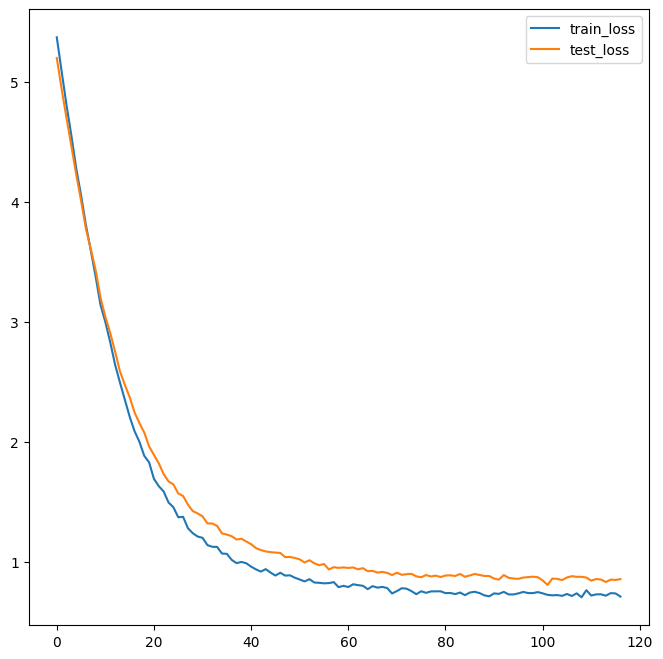

In [46]:
plt.figure(figsize=(8, 8))
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('VGGFace.pth'))
model.eval()
with torch.no_grad():
    acc = 0.0
    test_loss = 0.0
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        test_loss += loss.item()
        acc += (pred.argmax(dim=1) == y).sum().item()
    print(f"test_loss: {test_loss / len(test_loader):.4f}, Accuracy: {acc / len(test_loader.dataset)}")

test_loss: 0.8647, Accuracy: 0.953551912568306
